In [80]:
import json

import markdownify

filename = "data.json"

with open(filename, encoding="utf-8") as file:
    data = json.load(file)

data = data["db"][0]['data']

In [81]:
posts = data["posts"]

In [82]:
def clean_post(post):
    cleaned_post = {}

    try:
        cleaned_post['markdown'] = json.loads(post['mobiledoc'])['cards'][0][1]['markdown']
    except (KeyError, IndexError):
        cleaned_post['markdown'] = markdownify.markdownify(post['html'])

    contains = ['title', 'slug', 'published_at', 'comment_id']
    for key in contains:
        cleaned_post[key] = post[key]

    return cleaned_post

In [84]:
for post in posts:
    clean = clean_post(post)
    

{'id': '636f34209f01a218279aab05',
 'uuid': 'd7a971c8-e974-4157-8771-d51789f6b7cd',
 'title': '비트토렌트 한글판 다운로드 방법',
 'slug': 'bittorrent-korean',
 'mobiledoc': '{"version":"0.3.1","atoms":[],"cards":[["bookmark",{"version":"1.0","type":"bookmark","url":"https://digit-all.tistory.com/36","metadata":{"url":"https://digit-all.tistory.com/36","title":"[2022년] 토렌트 다운로드 프로그램 추천 Top 5","description":"토렌트, 많이 사용하시나요? 깜빡 잊고 보지 못한 프로그램을 다운받거나, 영화관에서 미처 보지 못했던 영화를 주말에 다운받아 본다던지.. 여러가지로 유용한게 바로 토렌트죠. 물론 저작권을 지켜서 다운받아야 하고, 때로는 다운받기만 해도 처벌받는 파일이 있거나, 파일 안에 바이러스가 들어있어 랜섬웨어에 감염되는 경우도 있습니다. 물론 바이러스 검사를 자동으로 해주는 토렌트 프로그램도 있지만, 가장 좋은 건 꼭 내가 어떤 파일을 다운받고 있는지 확인하는 것입니다. 당연히 내가 받고자 하는 파일 외에 바이러스가 들어있다면 다운받지 말아야…","author":"일시불로그","publisher":"TISTORY","thumbnail":"https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FTASbP%2FbtqGdsJklRJ%2FgoRRTGSO6vWxTgPjbKdAik%2Fimg.jpg","icon":"https://digit-all.tistory.com/favicon.ico"}}],["bookmark",{"version":"1.0","type":"bookm
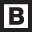
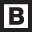

In [85]:
posts[-1]